Notebook for the assessment of the PCF project.

In [1]:
cd ..

C:\Users\giaco\pcf-project\abm


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import csv

from abm.model import SBPAdoption

from abm.custom_transformers import (
    TransformCensusFeatures,
    TransformClimateFeatures,
    TransformSoilFeatures,
    )

In [3]:
%matplotlib inline

mpl.rc('axes', labelsize=14)

tick_size = 11
mpl.rc('xtick', labelsize=tick_size)
mpl.rc('ytick', labelsize=tick_size)

plt.rcParams["font.family"] = "Calibri"

In [4]:
# Size of figures
fig_x = 8
fig_y = 5

In [5]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\abm")

In [6]:
# How to display floats
pd.options.display.float_format = '{:.6f}'.format
#np.set_printoptions(precision=6)
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [7]:
# Where to save the figures
PROJECT_ROOT_DIR = "pcf_project_assessment"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "output/images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Real data loading

In [8]:
path_to_adoption_port_real = "./carbon_sequestration/data/SBP yearly adoption - Portugal.csv"
yearly_adoption_portugal_real = pd.read_csv(path_to_adoption_port_real, index_col=0)
yearly_adoption_portugal_real.drop(1995, inplace=True)

# Model runs and data collection

In [9]:
n_runs = 25

In [10]:
def collect_data_run(model, n_run, df):  
    # Aggregate adoption
    aggr_adoption_out = model.datacollector.get_model_vars_dataframe()
    aggr_adoption_out.set_index('Year', inplace=True)
    col_name = 'Run ' + str(n_run+1)
    df[col_name] = aggr_adoption_out['Yearly area of SBP sown [ha/y]']

## Model with payments from 2013 to 2020

In [11]:
start_year = 2013
stop_year = 2021

In [11]:
years = np.arange(start_year, stop_year)

In [12]:
# Set dataframes to collect yearly adoption in Portugal with payments
yearly_adoption_portugal_pred = pd.DataFrame(index=years)
yearly_adoption_portugal_pred.index.rename('Year', inplace=True)

In [13]:
%%time

for i in range(n_runs):
    model = SBPAdoption(initial_year=start_year, seed=i)
    for y in range(start_year, stop_year):
        model.step()
        print("Run n° " + str(i+1) + ": year " + str(y) + " step completed.")
    collect_data_run(model, i, yearly_adoption_portugal_pred)

Run n° 1: year 2013 step completed.
Run n° 1: year 2014 step completed.
Run n° 1: year 2015 step completed.
Run n° 1: year 2016 step completed.
Run n° 1: year 2017 step completed.
Run n° 1: year 2018 step completed.
Run n° 1: year 2019 step completed.


KeyboardInterrupt: 

## Model without payments from 2009 to 2020

In [12]:
start_year_nop = 2009
stop_year_nop = 2021

In [15]:
years_nop = np.arange(start_year_nop, stop_year_nop)

In [16]:
# Set dataframes to collect yearly adoption in Portugal without payments
yearly_adoption_portugal_pred_nop = pd.DataFrame(index=years_nop)
yearly_adoption_portugal_pred_nop.index.rename('Year', inplace=True)

In [17]:
%%time

sbp_payments_path = "./data/sbp_payments_all0.xlsx"

for i in range(n_runs):
    model_nop = SBPAdoption(initial_year=start_year_nop, seed=i, sbp_payments_path=sbp_payments_path)
    for y in range(start_year_nop, stop_year_nop):
        model_nop.step()
        print("Run n° " + str(i+1) + ": year " + str(y) + " step completed.")
    collect_data_run(model_nop, i, yearly_adoption_portugal_pred_nop)

Run n° 1: year 2009 step completed.
Run n° 1: year 2010 step completed.
Run n° 1: year 2011 step completed.


KeyboardInterrupt: 

## Save and load model output

In [19]:
os.mkdir("carbon_sequestration/output")
yearly_adoption_portugal_pred.to_csv("carbon_sequestration/output/estimation_with_paym_2013_2020")
yearly_adoption_portugal_pred_nop.to_csv("carbon_sequestration/output/estimation_no_paym_2009_2020")

FileExistsError: [WinError 183] Impossibile creare un file, se il file esiste già: 'carbon_sequestration/output'

In [13]:
yearly_adoption_portugal_pred = pd.read_csv("carbon_sequestration/output/estimation_with_paym_2013_2020", index_col='Year')
yearly_adoption_portugal_pred_nop = pd.read_csv("carbon_sequestration/output/estimation_no_paym_2009_2020", index_col='Year')

## Logistic extrapolation

In [14]:
r = 0.429
K = 109535
P0 = 2443

In [27]:
# Cumulative extrapolation
years = np.arange(1996, 2021)
log_extr = pd.Series(0, years)
for y in years:
    log_extr.loc[y] = K * P0 / ((K - P0) * np.exp(-r*(y - 1996)) + P0)

In [28]:
# Yearly extrapolation
years = np.arange(1996, 2021)
log_extr_d = pd.Series(0, years)
for y in years:
    log_extr_d.loc[y] = r * log_extr.loc[y] * (1 - log_extr.loc[y] / K)

# Calculation of additional sequestered carbon

In [17]:
yearly_adoption_portugal_pred_av = yearly_adoption_portugal_pred.mean(axis=1)
yearly_adoption_portugal_pred_nop_av = yearly_adoption_portugal_pred_nop.mean(axis=1)

In [18]:
# Calculate total carbon sequestration factor for 10 years
carb_seq_factors = [14.7, 11.54, 9.15, 7.30, 5.86, 4.72, 3.82, 3.10, 2.53, 2.06]
carb_seq_fact_10y = sum(carb_seq_factors)
print(carb_seq_fact_10y)

64.78


## 2009 - 2012 (Observed adoption vs. Counterfactual estimation)

In [19]:
id_obs = yearly_adoption_portugal_real.index
id_pred_nop = yearly_adoption_portugal_pred_nop_av.index

In [21]:
area_obs_09_12 = yearly_adoption_portugal_real.loc[id_obs >= 2009].sum()['Yearly adoption']
area_pred_nop_09_12 = yearly_adoption_portugal_pred_nop_av.loc[id_pred_nop < 2013].sum()
diff_area_09_12 = area_obs_09_12 - area_pred_nop_09_12

carb_seq_09_12_10y = diff_area_09_12 * carb_seq_fact_10y

In [22]:
print("Additional SBP area installed during the PCF project (2009-2012): ", str(diff_area_09_12), "ha")
print("Additional carbon sequestered during the PCF project (2009-2012): ", str(carb_seq_09_12_10y/1e6), "Mt CO2")

Additional SBP area installed during the PCF project (2009-2012):  35165.00791258531 ha
Additional carbon sequestered during the PCF project (2009-2012):  2.2779892125772765 Mt CO2


## 2013 - 2020 (Estimated adoption vs. counterfactual estimation)

In [23]:
id_pred = yearly_adoption_portugal_pred.index

In [24]:
area_pred_13_20 = yearly_adoption_portugal_pred_av.sum()
area_pred_nop_13_20 = yearly_adoption_portugal_pred_nop_av[id_pred_nop >= 2013].sum()
diff_area_13_20 = area_pred_13_20 - area_pred_nop_13_20

carb_seq_09_12_10y = diff_area_09_12 * carb_seq_fact_10y

In [25]:
carb_seq_13_20_10y = diff_area_13_20 * carb_seq_fact_10y
print("Additional SBP area installed during the PCF project (2013-2020): ", str(diff_area_13_20), "ha")
print("Additional carbon sequestered after the PCF project (2013-2020): ", str(carb_seq_13_20_10y/1e6), "Mt CO2")

Additional SBP area installed during the PCF project (2013-2020):  -10279.416404399984 ha
Additional carbon sequestered after the PCF project (2013-2020):  -0.665900594677031 Mt CO2


## 2009 - 2020 (Total)

In [26]:
diff_area_tot = diff_area_09_12 + diff_area_13_20
carb_seq_tot = diff_area_tot * carb_seq_fact_10y
print("Additional SBP area installed thanks to the PCF project (2009-2020): ", str(diff_area_tot), "ha")
print("Additional carbon sequestered thanks to the PCF project (2009-2020): ", str(carb_seq_tot/1e6), "Mt CO2")

Additional SBP area installed thanks to the PCF project (2009-2020):  24885.591508185324 ha
Additional carbon sequestered thanks to the PCF project (2009-2020):  1.6120886179002454 Mt CO2


# Comparison with previous logistic extrapolation

In [41]:
id_log = log_extr_d.index
area_log_09_12 = log_extr_d.loc[(id_log >= 2009) & (id_log <= 2012)].sum()
diff_area_09_12_extr = area_pred_nop_09_12 - area_log_09_12

In [44]:
print("Difference of additional SBP area installed during the PCF project estimated by the two extrapolations: ",
      str(diff_area_09_12_extr), "ha")

Difference of additional SBP area installed during the PCF project estimated by the two extrapolations:  1893.5020353753644 ha


In [51]:
# In percentage over previous estimation of additional area
perc_diff = (diff_area_09_12_extr / (area_obs_09_12 - area_log_09_12) * 100)
print("Difference of additional SBP area installed during the PCF project estimated by the two extrapolations, in %: ",
      str(perc_diff), "%")

Difference of additional SBP area installed during the PCF project estimated by the two extrapolations, in %:  5.1094931718364025 %


# Plot of runs and average value over real adoption

In [45]:
def plot_differential_adoption_all(predicted_adoption, predicted_adoption_no_p, real_adoption, log_extr_adoption,
                                   max_y, fig_title):
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(fig_x, fig_y)
    ts = 16
    plt.xticks(fontsize=ts) 
    plt.yticks(fontsize=ts)
    ls = 20
    ax_pr.set_xlabel("Years", fontsize=ls)
    ax_pr.set_ylabel("Area installed [ha]", fontsize=ls)
    #ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in np.arange(1996, 2021) if year%4 == 0]
    ax_pr.set_xticks(xticks)
    yticks = np.arange(0, 21000, 5000)
    ax_pr.set_yticks(yticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    pred_adoption_av = predicted_adoption.mean(axis=1)
    pred_adoption_no_p_av = predicted_adoption_no_p.mean(axis=1)
    pred_vals = pred_adoption_av.values
    pred_nop_vals = pred_adoption_no_p_av.values
    
    lw = 1
    ms = 14

    ax_pr.plot(real_adoption.index, real_adoption.values, 'r--', linewidth=lw, marker='.', markersize=ms,
               label='Observed')
    ax_pr.plot(pred_adoption_av.index, pred_vals, 'c--', linewidth=lw, marker='.', markersize=ms,
               label='Estimated')
    point1 = [real_adoption]
    ax_pr.plot([2012, 2013], [real_adoption.loc[2012], pred_adoption_av.loc[2013]], 'c--', linewidth=lw)
    ax_pr.plot(pred_adoption_no_p_av.index, pred_nop_vals, 'b--', linewidth=lw, marker='.', markersize=ms,
               label='Estimated without payments')
    ax_pr.plot([2008, 2009], [real_adoption.loc[2008], pred_adoption_no_p_av.loc[2009]], 'b--', linewidth=lw)

    log_extr_from_2009 = log_extr_adoption.loc[log_extr_adoption.index > 2008]
    ax_pr.plot(log_extr_from_2009.index, log_extr_from_2009.values, 'g--', linewidth=lw, marker='.', markersize=ms,
               label='Previous extrapolation')
    #ax_pr.plot([2008, 2009], [real_adoption.loc[2008], log_extr_from_2009.loc[2009]], 'g--', linewidth=lw)
    ax_pr.legend(loc='upper left', fontsize=15)
    ax_pr.spines['top'].set_visible(False)
    ax_pr.spines['right'].set_visible(False)
    ax_pr.spines['left'].set_visible(False)

    x = [year for year in np.arange(2008, 2021)]
    y1 = pd.concat([real_adoption.loc[real_adoption.index >= 2008]['Yearly adoption'], pred_adoption_av])
    y2 = np.insert(pred_nop_vals, 0, real_adoption.loc[2008, 'Yearly adoption'])
    ax_pr.fill_between(x, y1, y2, where=(y2 >= y1), facecolor='red', alpha=0.5, interpolate=True)
    ax_pr.fill_between(x, y1, y2, where=(y2 <= y1), facecolor='green', alpha=0.5, interpolate=True)
    
    #x = [year for year in np.arange(2008, 2013)]
    #log_extr_from_2009[2008] = real_adoption.loc[2008, 'Yearly adoption']
    #log_extr_from_2009.sort_index(inplace=True)
    #y1 = log_extr_from_2009.loc[(log_extr_from_2009.index >= 2008) & (log_extr_from_2009.index <= 2012)]
    #y2 = np.insert(pred_nop_vals, 0, real_adoption.loc[2008, 'Yearly adoption'])[:5]
    #ax_pr.fill_between(x, y1, y2, where=(y2 >= y1), facecolor='blue', alpha=0.5, interpolate=True)
    
    save_fig((fig_title)) 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Saving figure PCF assessment_all


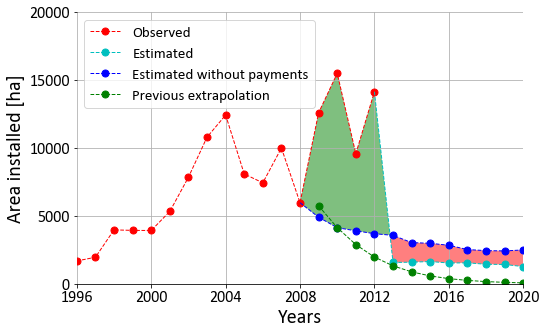

In [46]:
title = "PCF assessment_all"
plot_differential_adoption_all(yearly_adoption_portugal_pred, yearly_adoption_portugal_pred_nop,
                                yearly_adoption_portugal_real, log_extr_d, 20000, title)